# ARIMA

Useremo i dati dei passeggeri per stimare un modello ARIMA. Faremo così inizialmente perchè con gli stock prices non siamo ancora in grado di capire se è un problema di setup del modello o semplice impossibilità di predizione degli stock prices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


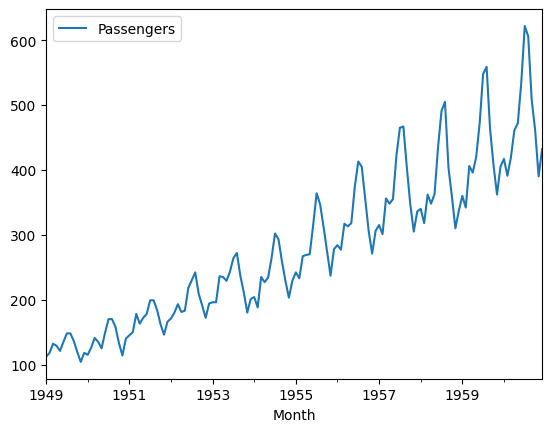

In [4]:
df.plot();

In [5]:
# Tempo fa abbiamo fatto questa operazione mandualmente usando lo shift e la differenza.
# Pandas, in realtà, mette a disposizione molte funzioni per l'analisi di time series e, in particolare, per la finanza.
df['1stDiff'] = df["Passengers"].diff()

#### Considerazioni sul Plot sotto

Possiamo notare come la differenza elimina il trend, come "promesso". Viene effettuato il de-trending.
Tuttavia la serie temporale differenziata non è così tanto "stazionaria": c'è una componente ciclica che si può notare, ed essa aumenta nel tempo

<Axes: xlabel='Month'>

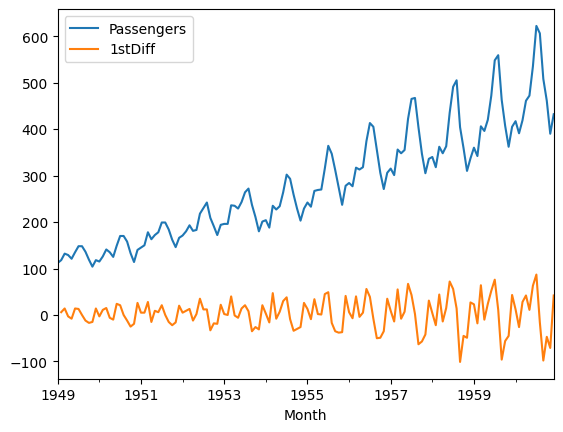

In [6]:
df.plot()

In [7]:
df["LogPassengers"] = np.log(df["Passengers"])

#### Considerazioni sul Plot sotto

A differenza dei dati sui passeggeri (Non in logaritmo), questa serie temporale mostra un trend crescente ma essendo tutto "squeezed" nel logaritmo, la componente ciclica non sembra poi così diversa ad ogni ciclo. 

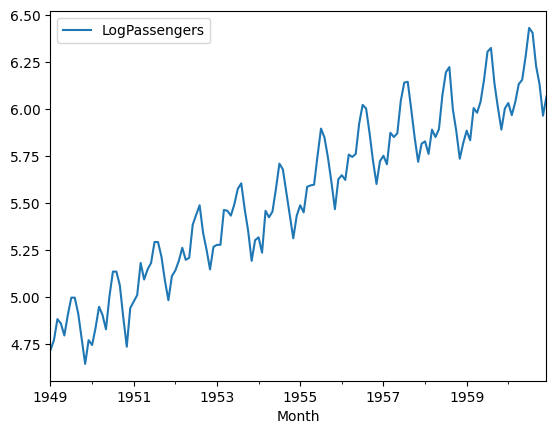

In [8]:
df[["LogPassengers"]].plot();

In [9]:
from statsmodels.tsa.arima.model import ARIMA

In [10]:
df.index.freq = "MS"

In [11]:
N_Test = 12
train = df.iloc[:-N_Test]
test = df.iloc[-N_Test:]

## Test su casi speciali di ARIMA

Andiamo a vedere se il valore della time-series dipende linearmente unicamente dai valori precedenti. Facciamo alcuni test

In [12]:
# Prendiamo un modello AR che si basa solo sul valore precedente. L'ordine di ARIMA sarà 1, 0, 0
arima = ARIMA(train["Passengers"], order=(1,0,0))

In [13]:
arima_results = arima.fit()

In [14]:
train_only_predicts = arima_results.predict(start=train.index[0], end=train.index[-1])

In [15]:
df["AR(1)"] = train_only_predicts

#### Considerazioni Plot sotto

Notiamo ancora una volta questo comportamento "in ritardo". Questo avviene perchè il modello altro non può fare che prevedere il valore precedente, non avendo altro su cui basarsi. Questo comportamento in delay è indice di un errore di modeling, da quello che abbiamo potuto constatare anche dall'esperienza maturata in Holt Winters

<Axes: xlabel='Month'>

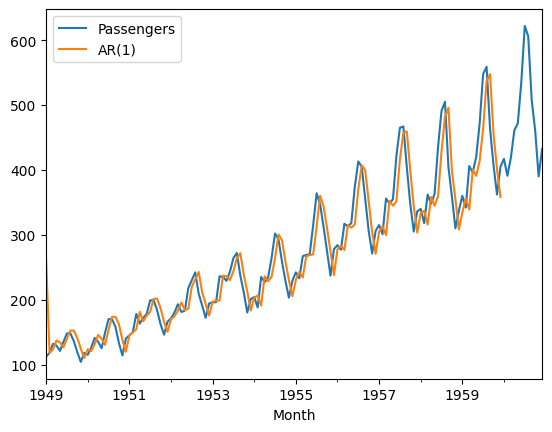

In [16]:
df[["Passengers", "AR(1)"]].plot()

In [17]:
"""
NB: qui noi abbiamo una differenza col corso. La vecchia versione della libreria, con forecast, restituiva il valore, lo standard error
e il confidence interval. Usando solo "Forecast", ora, otteniamo invece il risultato. Per ottenere tutto quanto, dovremmo usare il metodo
get_forecast() che ci restituisce un oggetto del tipo "PredictionResults" sulla quale, applicando il metodo summary_frame() ci restituisce
un dataframe con gli intervalli di confidenza.
A noi servirebbero solo le predizioni, ma seguiamo il corso :)
"""
# forecast = arima_results.forecast(N_Test)
forecast = arima_results.get_forecast(N_Test).summary_frame()

In [18]:
forecast

Passengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1960-01-01,399.554855,31.070288,338.658210,460.451500
1960-02-01,394.317763,43.108747,309.826171,478.809354
1960-03-01,389.280774,51.811465,287.732168,490.829379
1960-04-01,384.436243,58.724542,269.338256,499.534230
1960-05-01,379.776815,64.462680,253.432284,506.121347
1960-06-01,375.295420,69.349242,239.373402,511.217437
1960-07-01,370.985253,73.581140,226.768868,515.201638
1960-08-01,366.839773,77.289789,215.354570,518.324977
1960-09-01,362.852687,80.568591,204.941150,520.764224
1960-10-01,359.017943,83.487048,195.386337,522.649550


In [19]:
# Uniamo il forecast al test, di prima. Dobbiamo fare dei giri perchè df.loc[:-N_Test, "AR(1)"] non funziona
all_arima_predicted = np.r_[train_only_predicts.to_numpy(), forecast["mean"].to_numpy()]
df["AR(1)"] = all_arima_predicted

# ALTERNATIVAMENTE
df["AR(1)"] = pd.concat([train_only_predicts, forecast["mean"]])

#### Considerazioni Plot sotto

Il modello fa abbastanza schifo.
Non è nemmeno in grado di comprendere che alla base ci sia un trend verso l'alto. Lo miglioreremo.

<Axes: xlabel='Month'>

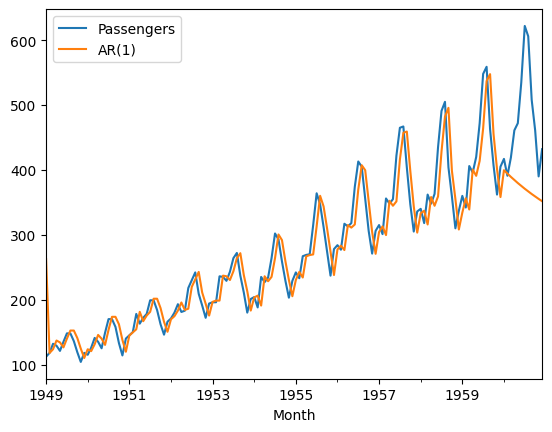

In [20]:
df[["Passengers", "AR(1)"]].plot()

In [21]:
def plot_fit_and_forecast(df, arima_result, N_Test):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df["Passengers"], label="Data")

    fitted_values = arima_result.fittedvalues
    predicted_values = arima_result.get_forecast(N_Test).summary_frame()

    ax.plot(predicted_values["mean"], label = "Forecast")
    ax.plot(fitted_values, label = "Fitted")

    #ax.plot(predicted_values["mean_ci_lower"], label="Lower Confidence Interval")
    #ax.plot(predicted_values["mean_ci_upper"], label="Upper Confidence Interval")

    ax.fill_between(predicted_values.index, predicted_values["mean_ci_lower"], predicted_values["mean_ci_upper"],
                    color="red", alpha=0.2)

    ax.legend()

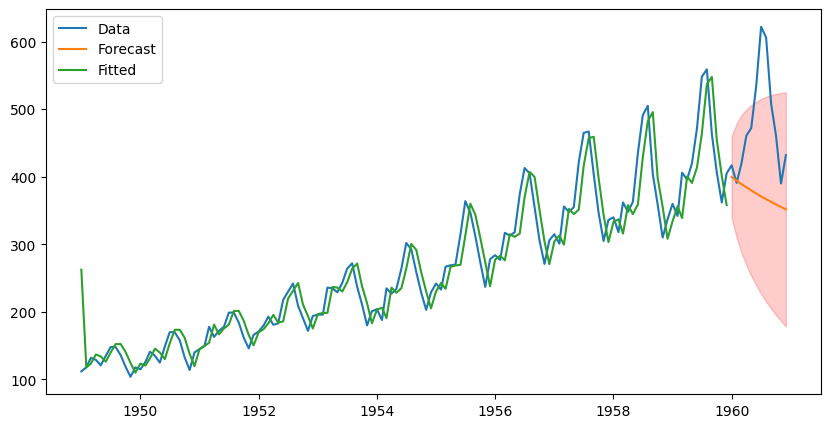

In [22]:
plot_fit_and_forecast(df, arima_results, N_Test)

### AR Model con 10 timesteps

Considerando il plot sotto, vediamo che inserire 10 timestep prima migliora di molto il risultato

In [23]:
arima = ARIMA(train["Passengers"], order=(10,0,0))
arima_results = arima.fit()

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


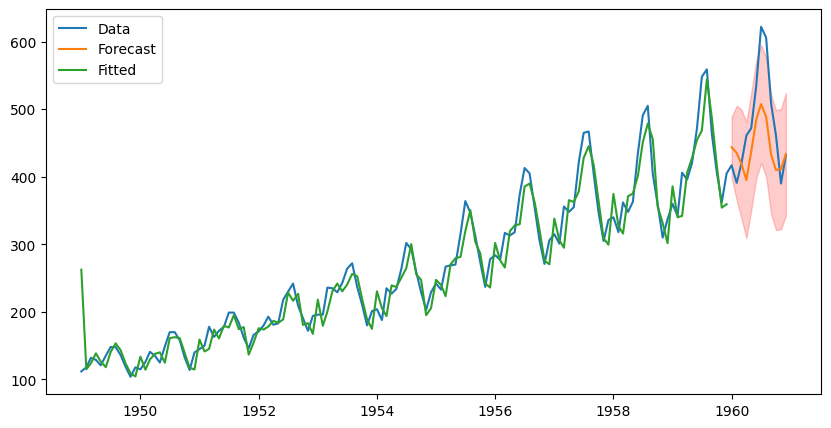

In [24]:
plot_fit_and_forecast(df, arima_results, N_Test)

### MA Model con 1 timestep

Il moving average model da solo fa abbastanza schifo, Proviamo a  combinarli in un ARMA.
Il forecast che vediamo, infatti, copia sempre l'ultimo valore in avanti, esattamente come ci aspettavamo.

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


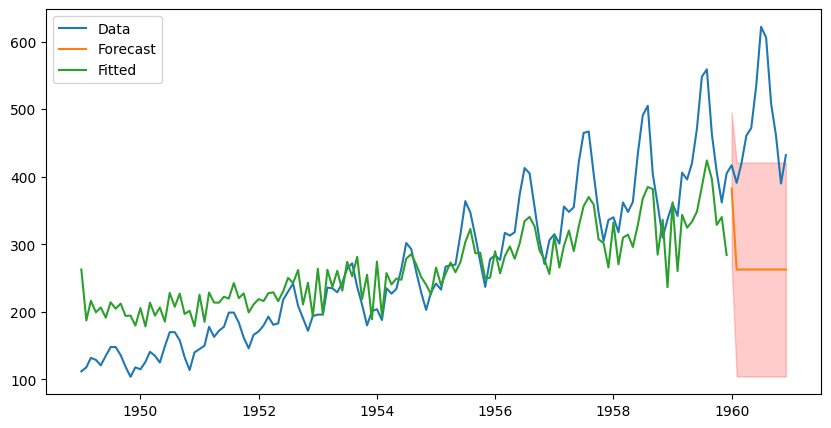

In [25]:
arima = ARIMA(train["Passengers"], order=(0,0,1))
arima_results = arima.fit()
plot_fit_and_forecast(df, arima_results, N_Test)

### ARMA(10,1)


C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


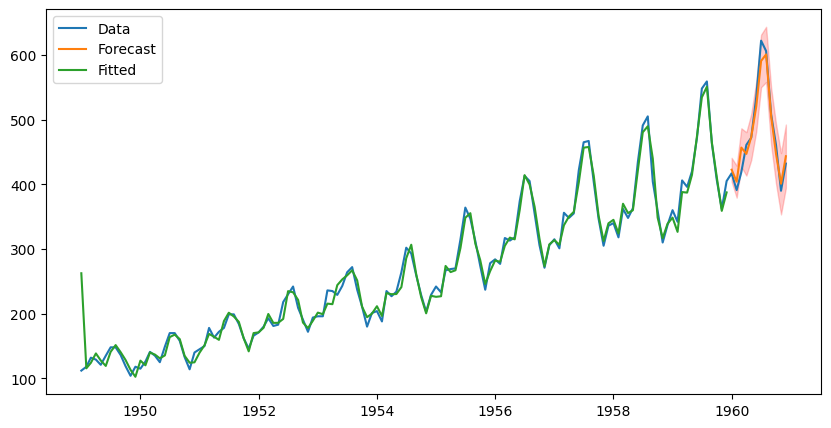

In [26]:
arima = ARIMA(train["Passengers"], order=(20,0,8))
arima_results = arima.fit()
plot_fit_and_forecast(df, arima_results, N_Test)

## Arima Completo

In [27]:
df["LogPassengers1stDifference"] = df["LogPassengers"].diff()

count    143.000000
mean       0.009440
std        0.106556
min       -0.223144
25%       -0.080024
50%        0.014815
75%        0.105882
max        0.223144
Name: LogPassengers1stDifference, dtype: float64

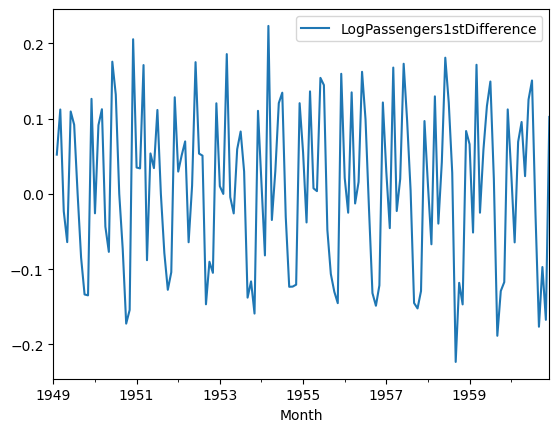

In [28]:
df[["LogPassengers1stDifference"]].plot();
df["LogPassengers1stDifference"].describe()

### ARIMA(8,1,1)

Proviamo ad applicare il modello ARIMA(12,1,1). La scelta dei parametri è ovviamente da tunare, il corso indicava un AR di 8, l'ho modificato a 12 per essere più coerenti col trend ciclico. Questo valore indica gli istanti precedenti. Il primo 1 che si vede indica quante volte effettuare time difference (basta una sola volta, guardando il plot sopra). Infine, con il secondo "1", applichiamo gli errori del solo istante precedente semplicemente per avere un modello ARIMA completo.

In [29]:
def plot_fit_and_forecast_ARIMA(df, arima_result, N_Test, d, column="Passengers"):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df[column], label="Data")

    train = df.iloc[:-N_Test]

    # typ="levels" accumula il segnale della time.-difference sul valore precedente
    fitted_values = arima_result.predict(start=train.index[d], end=train.index[-1], typ="levels")
    
    predicted_values = arima_result.get_forecast(N_Test).summary_frame()

    ax.plot(predicted_values["mean"], label = "Forecast")
    ax.plot(fitted_values, label = "Fitted")

    #ax.plot(predicted_values["mean_ci_lower"], label="Lower Confidence Interval")
    #ax.plot(predicted_values["mean_ci_upper"], label="Upper Confidence Interval")

    ax.fill_between(predicted_values.index, predicted_values["mean_ci_lower"], predicted_values["mean_ci_upper"],
                    color="red", alpha=0.2)

    ax.legend()
    ax.set_title(f"ARIMA analysis on column: {column}")

In [30]:
# Plottiamo adesso sulla time difference
### ATTENZIONE!!! Questo nel corso era possibile. Ora tuttavia, non possiamo più confrontare il solo segnale.
def plot_difference(df, arima_result, N_Test, order, column):

    diff = df[column].diff()
    train = diff.iloc[:-N_Test]
    test = diff.iloc[-N_Test:]
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(diff, label="Data")

    

    # typ="levels" accumula il segnale della time.-difference sul valore precedente
    fitted_values = arima_result.predict(start=train.index[order], end=train.index[-1], signal_only=True)
    predicted_values = arima_result.get_forecast(N_Test).summary_frame()
    forecasted_values = arima_result.predict(start=test.index[0], end=test.index[-1], signal_only=True)

    ax.plot(forecasted_values, label = "Forecast")
    ax.plot(fitted_values, label = "Fitted")

    #ax.plot(predicted_values["mean_ci_lower"], label="Lower Confidence Interval")
    #ax.plot(predicted_values["mean_ci_upper"], label="Upper Confidence Interval")

    ax.fill_between(predicted_values.index, predicted_values["mean_ci_lower"], predicted_values["mean_ci_upper"],
                    color="red", alpha=0.2)

    ax.legend()
    ax.set_title(f"ARIMA Difference Analysis on column: {column}")

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


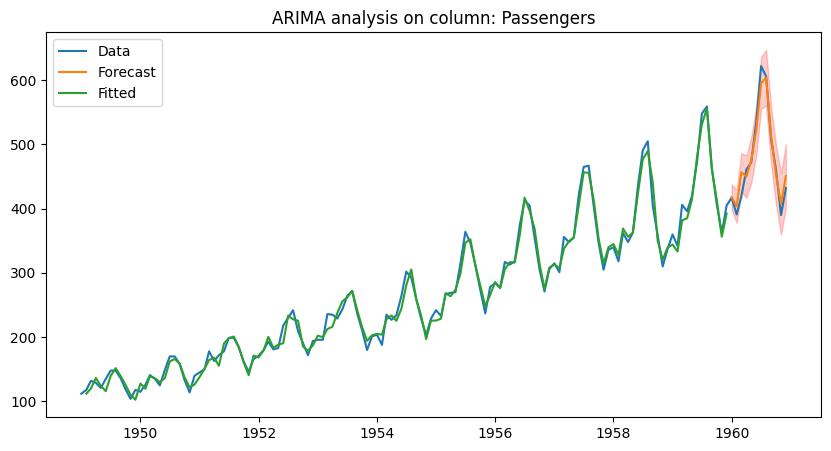

In [31]:
d = 1
arima = ARIMA(train["Passengers"], order=(12, d, 1))
arima_results = arima.fit()
plot_fit_and_forecast_ARIMA(df, arima_results, N_Test, d, "Passengers")

In [32]:
# Nel corso aveva senso, ora non più
# plot_difference(df, arima_results, N_Test, d, "Passengers")

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


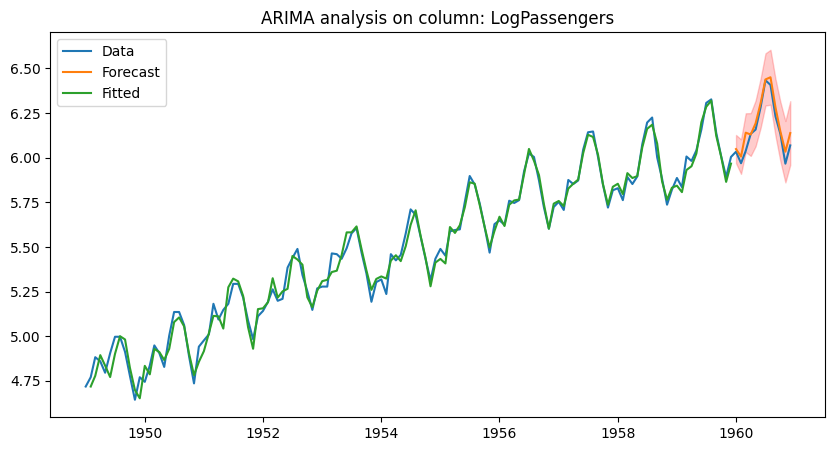

In [33]:
d = 1
arima = ARIMA(train["LogPassengers"], order=(12, d, 1))
arima_results_log = arima.fit()
plot_fit_and_forecast_ARIMA(df, arima_results_log, N_Test, d, "LogPassengers")

In [34]:
# Stesso di sopra
# plot_difference(df, arima_results_log, N_Test, d, "LogPassengers")

### Calcolo RMSE

In [35]:
def rmse(df, arima_result, N_Test, is_logged):

    y_true = df.iloc[-N_Test:]["Passengers"]
    forecasts = arima_result.get_forecast(N_Test).predicted_mean

    if is_logged:
        forecasts = np.exp(forecasts)

    return np.sqrt(np.mean((y_true - forecasts)**2))

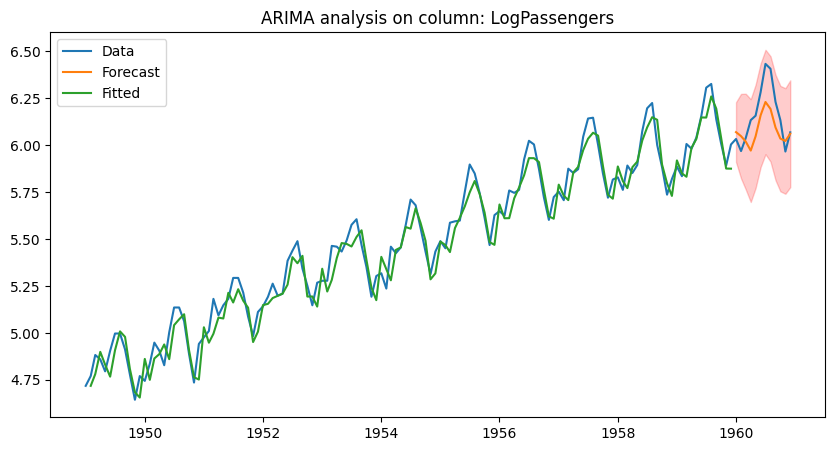

In [36]:
# Usiamo ARIMA(8,1,1) per confronto.
d = 1
arima = ARIMA(train["LogPassengers"], order=(8, d, 1))
arima_results_log_811 = arima.fit()
plot_fit_and_forecast_ARIMA(df, arima_results_log_811, N_Test, d, "LogPassengers")

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


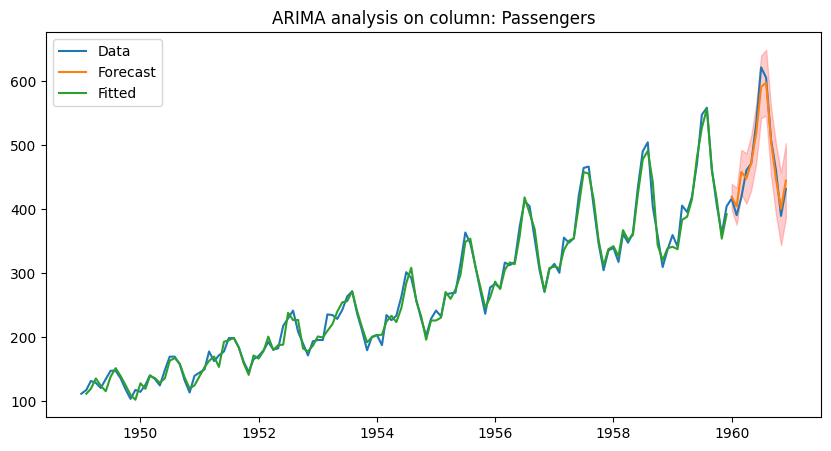

In [37]:
#ARIMA 12 1 0
d = 1
arima = ARIMA(train["Passengers"], order=(12, d, 0))
arima_results_1210 = arima.fit()
plot_fit_and_forecast_ARIMA(df, arima_results_1210, N_Test, d, "Passengers")

C:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


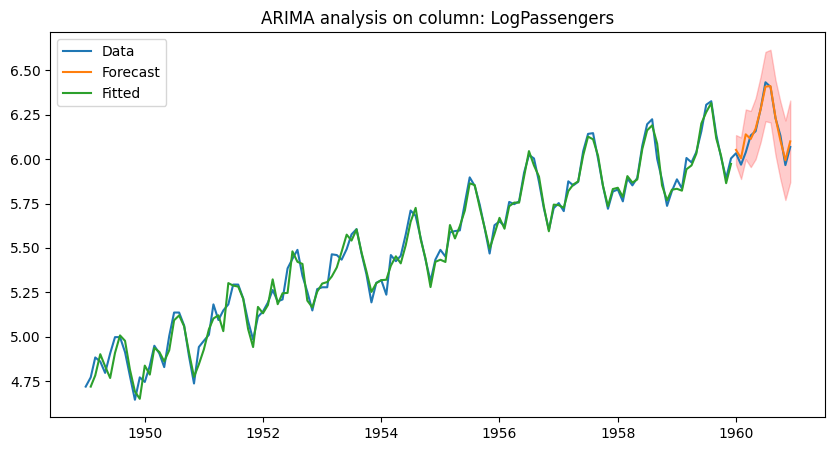

In [38]:
#ARIMA 12 1 0
d = 1
arima = ARIMA(train["LogPassengers"], order=(12, d, 0))
arima_results_log_1210 = arima.fit()
plot_fit_and_forecast_ARIMA(df, arima_results_log_1210, N_Test, d, "LogPassengers")

In [39]:
print(f"RMSE of ARIMA 12,1,0 on Passengers: {rmse(df, arima_results_1210, N_Test, False)}")
print(f"RMSE of ARIMA 12,1,0 on LogPassengers: {rmse(df, arima_results_log_1210, N_Test, True)}")
print(f"RMSE of ARIMA 12,1,1 on Passengers: {rmse(df, arima_results, N_Test, False)}")
print(f"RMSE of ARIMA 12,1,1 on LogPassengers: {rmse(df, arima_results_log, N_Test, True)}")
print(f"RMSE of ARIMA 8,1,1 on LogPassengers: {rmse(df, arima_results_log_811, N_Test, True)}")

RMSE of ARIMA 12,1,0 on Passengers: 17.491988305849752
RMSE of ARIMA 12,1,0 on LogPassengers: 16.11817898203138
RMSE of ARIMA 12,1,1 on Passengers: 16.67143953127737
RMSE of ARIMA 12,1,1 on LogPassengers: 22.039914863007688
RMSE of ARIMA 8,1,1 on LogPassengers: 61.61127278830516
